In [ ]:
##### %pip install pytorch_tabnet
##!pip install tensorflow
%pip install optuna
##!pip install --upgrade tensorflow
##!pip install scikeras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 11.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

def data_preprocess(df):
    # Isolate target and encode it
    y = df["cancer_type"]
    label_encoder_y = LabelEncoder()
    y_encoded = label_encoder_y.fit_transform(y)
    y = pd.Series(y_encoded)
    df = df.drop('cancer_type', axis=1)

    # Manually mapping and encoding categorical data
    categorical_mappings = {
        'cellularity': {'Low': 1, 'Moderate': 2, 'High': 3},
        'her2_status_measured_by_snp6': {'LOSS': 0, 'NEUTRAL': 1, 'GAIN': 3, 'UNDEF': 1},
        'primary_tumor_laterality': {'Right': 1, 'Left': -1},
    }

    for col, mapping in categorical_mappings.items():
        df[col] = df[col].str.strip().map(mapping).fillna(0)

    # Drop irrelevant columns
    df = df.drop('patient_id', axis=1)

    # One-hot encoding other categorical columns
    categorical_columns = ['pam50_+_claudin-low_subtype', 'er_status', 'er_status_measured_by_ihc',
                           'her2_status', 'inferred_menopausal_state', 'pr_status', '3-gene_classifier_subtype',
                           'death_from_cancer']
    df = pd.get_dummies(df, columns=categorical_columns)

    # Handle missing values for numeric columns
    numeric_imputations = {
        'tumor_size': df['tumor_size'].mean(),
        'mutation_count': df['mutation_count'].mean(),
        'neoplasm_histologic_grade': 3,  # Mode or specific domain-related value
    }

    for col, value in numeric_imputations.items():
        df[col] = df[col].fillna(value)

    # Scaling numeric columns
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    return df, y_encoded, label_encoder_y

# Load data
df = pd.read_csv('data.csv')

# Preprocess data
X, y, label_encoder_y = data_preprocess(df)

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(enumerate(class_weights))

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Class weights:", class_weights_dict)
X

<ipython-input-25-a058f4fd6f97>:53: DtypeWarning: Columns (662,664,676,677,683,685,686,687) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data.csv')


Class weights: {0: 0.3119266055045872, 1: 3.280701754385965, 2: 20.77777777777778, 3: 2.2666666666666666}


,age_at_diagnosis,cellularity,chemotherapy,cohort,neoplasm_histologic_grade,her2_status_measured_by_snp6,hormone_therapy,primary_tumor_laterality,lymph_nodes_examined_positive,mutation_count,...,inferred_menopausal_state_Pre,pr_status_Negative,pr_status_Positive,3-gene_classifier_subtype_ER+/HER2- High Prolif,3-gene_classifier_subtype_ER+/HER2- Low Prolif,3-gene_classifier_subtype_ER-/HER2-,3-gene_classifier_subtype_HER2+,death_from_cancer_Died of Disease,death_from_cancer_Died of Other Causes,death_from_cancer_Living
0,-0.507742,0.864479,1.948043,-1.342760,0.870086,-0.433436,0.776807,1.069919,0.241813,-0.897731,...,False,False,True,True,False,False,False,True,False,False
1,-1.348332,-0.439211,-0.513336,1.097041,-2.203463,-1.579056,0.776807,-0.984765,-0.502533,0.295497,...,True,False,True,False,True,False,False,False,False,True
2,1.029203,0.864479,-0.513336,0.283774,0.870086,-0.433436,0.776807,1.069919,0.986159,-0.659085,...,False,True,False,True,False,False,False,True,False,False
3,-0.695402,0.864479,-0.513336,0.283774,-0.666689,-0.433436,-1.287320,1.069919,-0.502533,1.011434,...,False,False,True,False,True,False,False,False,False,True
4,2.042718,-0.439211,-0.513336,-1.342760,0.870086,1.857803,0.776807,-0.984765,-0.006302,-1.136377,...,False,True,False,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1491,-0.834208,-0.439211,-0.513336,0.283774,0.870086,-0.433436,0.776807,1.069919,0.241813,-0.897731,...,False,False,True,False,True,False,False,False,True,False
1492,0.011810,0.864479,-0.513336,0.283774,0.870086,-0.433436,0.776807,1.069919,-0.254418,0.295497,...,False,False,True,False,False,False,False,False,True,False
1493,1.748822,-0.439211,-0.513336,1.097041,0.870086,-0.433436,0.776807,0.042577,-0.254418,-0.181794,...,False,True,False,True,False,False,False,False,True,False
1494,-0.016106,0.864479,-0.513336,1.097041,0.870086,-0.433436,0.776807,1.069919,-0.502533,0.056851,...,False,True,False,True,False,False,False,False,False,True


In [ ]:
#import pandas as pd

# Load both datasets
#data = pd.read_csv('data.csv')
#clean = pd.read_csv('clean.csv')

# Assuming 'data' has a column 'cancer_type' and 'clean' does not
# Add a 'cancer_type' column to 'clean' filled with NaN or a placeholder if appropriate
#clean['cancer_type'] = pd.NA  # Use an appropriate placeholder if necessary

# Concatenate datasets vertically
#combined_data = pd.concat([data, clean], ignore_index=True)

# Save the combined dataset
#combined_data.to_csv('combined_dataset.csv', index=False)


<ipython-input-10-75d8f44544fe>:4: DtypeWarning: Columns (662,664,676,677,683,685,686,687) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data.csv')


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

# Assuming you have your training data loaded into X_train and y_train
# Number of unique classes
num_classes = len(np.unique(y_train))

# Define the model architecture with L2 regularization
model = Sequential([
    Dense(32, activation='relu', kernel_regularizer=l2(0.02), input_shape=(X_train.shape[1],)),
    Dropout(0.13),  # Use the optimal dropout rate found
    Dense(32, activation='relu', kernel_regularizer=l2(0.02)),
    Dropout(0.13),  # Consistent dropout rate in the second layer
    Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.02))  # Using num_classes dynamically
])

# Compile the model with the optimized parameters
model.compile(optimizer='sgd',  # Use SGD optimizer as found in tuning
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary to check the architecture including L2 regularization
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_54 (Dense)                     │ (None, 32)                  │          22,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,684 (92.52 KB)

 Trainable params: 23,684 (92.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(y_train.shape)


(1196,)


In [ ]:
import numpy as np

# Convert data to float32
X_train = np.array(X_train).astype('float32')
y_train = np.array(y_train).astype('float32')

# Check for any remaining NaN values in the dataset
if np.any(np.isnan(X_train)) or np.any(np.isnan(y_train)):
    X_train = np.nan_to_num(X_train)
    y_train = np.nan_to_num(y_train)

# Fitting the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Plot accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


ValueError: could not convert string to float: 'E542K'

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7902 - loss: nan 
Test Accuracy: 77.67%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


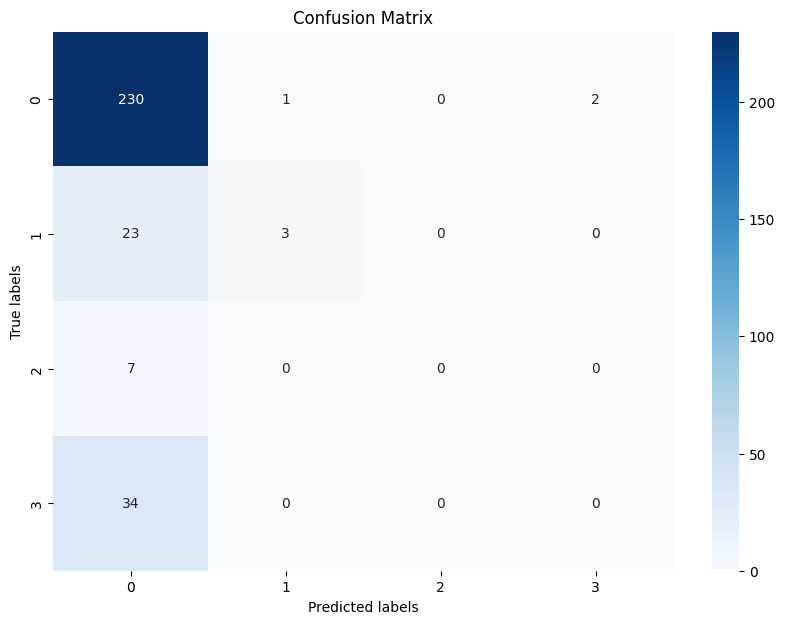

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.99      0.87       233
           1       0.75      0.12      0.20        26
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00        34

    accuracy                           0.78       300
   macro avg       0.38      0.28      0.27       300
weighted avg       0.67      0.78      0.70       300



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Convert and check types
X_test = np.array(X_test).astype('float32')
y_test = np.array(y_test).astype('int32')

# Evaluate the model
try:
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test Accuracy: {test_acc * 100:.2f}%")

    # Predict the test set results
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print("Classification Report:\n", classification_report(y_test, y_pred_classes))

except ValueError as e:
    print("ValueError during model evaluation:", e)


In [ ]:

import optuna
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def create_model(trial):
    # Hyperparameters to tune
    optimizer_options = ['adam', 'sgd']
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    neurons = trial.suggest_categorical('neurons', [32, 64, 128])

    # Model definition
    model = Sequential([
        Dense(neurons, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(dropout_rate),
        Dense(neurons, activation='relu'),
        Dropout(dropout_rate),
        Dense(len(np.unique(y_train)), activation='softmax')
    ])

    # Compile model
    optimizer = trial.suggest_categorical('optimizer', optimizer_options)
    if optimizer == 'adam':
        opt = Adam()
    elif optimizer == 'sgd':
        opt = SGD()
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train, epochs=50, verbose=0, validation_split=0.1)
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))




[I 2024-05-02 10:44:19,870] A new study created in memory with name: no-name-ab2cd062-14f3-4747-a88e-4e334e75cfe7
<ipython-input-9-1e776cbafc89>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
[I 2024-05-02 10:44:27,081] Trial 0 finished with value: 0.7866666913032532 and parameters: {'dropout_rate': 0.11037138386128512, 'neurons': 32, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.7866666913032532.
[I 2024-05-02 10:44:34,797] Trial 1 finished with value: 0.753333330154419 and parameters: {'dropout_rate': 0.4130757599112699, 'neurons': 128, 'optimizer': 'adam'}. Best is trial 0 with value: 0.7866666913032532.
[I 2024-05-02 10:44:45,683] Trial 2 finished with value: 0.7799999713897705 and parameters: {'dropout_rate': 0.47352469717153134, 'neurons': 128, 'optimizer': 'sgd'}. Best 

Best trial:
  Value:  0.7900000214576721
  Params: 
    dropout_rate: 0.1294683955834527
    neurons: 32
    optimizer: sgd


In [ ]:
%pip install scikeras

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

from scikeras.wrappers import KerasClassifier

# Function to create the model, required for KerasClassifier
def create_model():
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.02)),
        Dropout(0.13),
        Dense(32, activation='relu', kernel_regularizer=l2(0.02)),
        Dropout(0.13),
        Dense(len(np.unique(y_train)), activation='softmax', kernel_regularizer=l2(0.02))
    ])
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, epochs=100, batch_size=32, verbose=0)

# Evaluate using 10-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(model, X_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Baseline: 79.51% (3.75%)
